In [1]:
import argparse
import logging
import os
import pickle
import random
import shutil
import time
from typing import Union, Tuple, List, Dict
import warnings
import numpy as np
import torch
import joblib
from sklearn.model_selection import train_test_split
import pandas as pd
from scipy import stats
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tqdm import tqdm, trange
from torch.utils import tensorboard
from torch.utils.tensorboard import SummaryWriter
import librosa
import IPython.display as ipd

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
drum_audio, sample_rate  =  librosa.load("/kaggle/input/drumpan/drmapan.wav",mono=False, duration=5, offset=0.5, sr=22500)
ipd.Audio(drum_audio, rate=sample_rate)

In [3]:
audio_df = pd.DataFrame(drum_audio.T)
audio_df.insert(0,'Idx',0)
count = 0
for i in range(0, len(audio_df),24):
    audio_df.iloc[i:i+24,0] = count
    count+=1
audio_df

Idx         0             1         2             3
0         0  0.011017 -5.175265e-04  0.012114  5.764650e-04
1         0  0.012962 -6.166072e-04  0.014255  6.780879e-04
2         0  0.013518 -6.534701e-04  0.014855  6.831560e-04
3         0  0.015395 -7.145880e-04  0.016913  7.748334e-04
4         0  0.015894 -7.440026e-04  0.017446  8.042963e-04
...     ...       ...           ...       ...           ...
96406  4016 -0.000161  1.373727e-08 -0.000161  1.178947e-08
96407  4016 -0.000098 -1.313134e-08 -0.000098 -8.315284e-09
96408  4017 -0.000065  1.203247e-08 -0.000065  5.156734e-09
96409  4017 -0.000037 -1.055732e-08 -0.000037 -2.421233e-09
96410  4017  0.000000  0.000000e+00  0.000000  0.000000e+00

[96411 rows x 5 columns]

In [4]:
audio_df1 = audio_df[audio_df['Idx']<4017].copy()

In [5]:
ipd.Audio(audio_df1.iloc[:,1:].T.to_numpy(), rate=sample_rate)

In [6]:
audio_df2 = audio_df1.copy()

In [7]:
audio1_min = audio_df1.iloc[:,1:].min()
audio1_max = audio_df1.iloc[:,1:].max()
audio1_range = audio1_max - audio1_min
audio_df2.iloc[:,1:] = (audio_df1.iloc[:,1:] - audio1_min)/audio1_range

In [8]:
audio_df3 = audio_df2.copy()
audio2_min = audio_df2.iloc[:,1:].min()
audio2_max = audio_df2.iloc[:,1:].max()
audio2_range = audio2_max - audio2_min
audio_df3.iloc[:,1:] = (audio_df2.iloc[:,1:] - audio2_min)/audio2_range

In [9]:
audio_df3

Idx         0         1         2         3
0         0  0.511756  0.474088  0.510826  0.485963
1         0  0.513819  0.473987  0.513035  0.486081
2         0  0.514408  0.473950  0.513654  0.486087
3         0  0.516400  0.473887  0.515777  0.486194
4         0  0.516930  0.473857  0.516326  0.486229
...     ...       ...       ...       ...       ...
96403  4016  0.499707  0.474615  0.497979  0.485290
96404  4016  0.499768  0.474615  0.498040  0.485290
96405  4016  0.499834  0.474615  0.498103  0.485290
96406  4016  0.499895  0.474615  0.498163  0.485290
96407  4016  0.499962  0.474615  0.498228  0.485290

[96408 rows x 5 columns]

In [10]:
import os
from typing import Union, Tuple, List
import warnings
warnings.filterwarnings("ignore")

# 3rd party modules
import numpy as np
import pandas as pd
from tqdm import tqdm
from scipy import stats
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import argparse
import logging
import os
import pickle
import random
import shutil
import time

# 3rd-Party Modules
import numpy as np
import torch
import joblib
from sklearn.model_selection import train_test_split

In [11]:
def imputer(
    curr_data: np.ndarray, 
    impute_vals: List, 
    zero_fill: bool = True
) -> np.ndarray:
    """Impute missing data given values for each columns.

    Args:
        curr_data (np.ndarray): Data before imputation.
        impute_vals (list): Values to be filled for each column.
        zero_fill (bool, optional): Whather to Fill with zeros the cases where 
            impute_val is nan. Defaults to True.

    Returns:
        np.ndarray: Imputed data.
    """

    curr_data = pd.DataFrame(data=curr_data)
    impute_vals = pd.Series(impute_vals)
    
    # Impute data
    imputed_data = curr_data.fillna(impute_vals)

    # Zero-fill, in case the `impute_vals` for a particular feature is `nan`.
    imputed_data = imputed_data.fillna(0.0)

    # Check for any N/A values
    if imputed_data.isnull().any().any():
        raise ValueError("NaN values remain after imputation")

    return imputed_data.to_numpy()

In [12]:
def data_preprocess(
#     file_name: str, 
    dataframe,
    max_seq_len: int, 
    padding_value: float=-1.0,
    impute_method: str="mode", 
    scaling_method: str="minmax", 
) -> Tuple[np.ndarray, np.ndarray, List]:
    """Load the data and preprocess into 3d numpy array.
    Preprocessing includes:
    1. Remove outliers
    2. Extract sequence length for each patient id
    3. Impute missing data 
    4. Normalize data
    6. Sort dataset according to sequence length

    Args:
    - file_name (str): CSV file name
    - max_seq_len (int): maximum sequence length
    - impute_method (str): The imputation method ("median" or "mode") 
    - scaling_method (str): The scaler method ("standard" or "minmax")

    Returns:
    - processed_data: preprocessed data
    - time: ndarray of ints indicating the length for each data
    - params: the parameters to rescale the data 
    """

    #########################
    # Load data
    #########################

    index = 'Idx'

#     # Load csv
#     print("Loading data...\n")
#     ori_data = pd.read_csv(file_name)
    
    ori_data = dataframe.copy()

    # Remove spurious column, so that column 0 is now 'admissionid'.
    if ori_data.columns[0] == "Unnamed: 0":  
        ori_data = ori_data.drop(["Unnamed: 0"], axis=1)

    #########################
    # Remove outliers from dataset
    #########################
    
    no = ori_data.shape[0]
    z_scores = stats.zscore(ori_data, axis=0, nan_policy='omit')
    z_filter = np.nanmax(np.abs(z_scores), axis=1) < 3
    ori_data = ori_data[z_filter]
    print(f"Dropped {no - ori_data.shape[0]} rows (outliers)\n")

    # Parameters
    uniq_id = np.unique(ori_data[index])
    no = len(uniq_id)
    dim = len(ori_data.columns) - 1

    #########################
    # Impute, scale and pad data
    #########################
    
    # Initialize scaler
#     if scaling_method == "minmax":
#         scaler = MinMaxScaler()
#         scaler.fit(ori_data)
#         params = [scaler.data_min_, scaler.data_max_]
    
#     elif scaling_method == "standard":
#         scaler = StandardScaler()
#         scaler.fit(ori_data)
#         params = [scaler.mean_, scaler.var_]

    # Imputation values
    if impute_method == "median":
        impute_vals = ori_data.median()
    elif impute_method == "mode":
        impute_vals = stats.mode(ori_data).mode[0]
    else:
        raise ValueError("Imputation method should be `median` or `mode`")    

    # TODO: Sanity check for padding value
    # if np.any(ori_data == padding_value):
    #     print(f"Padding value `{padding_value}` found in data")
    #     padding_value = np.nanmin(ori_data.to_numpy()) - 1
    #     print(f"Changed padding value to: {padding_value}\n")
    
    # Output initialization
    output = np.empty([no, max_seq_len, dim])  # Shape:[no, max_seq_len, dim]
    output.fill(padding_value)
    time = []

    audio_df3 = ori_data.copy()
    audio2_min = ori_data.iloc[:,1:].min()
    audio2_max = ori_data.iloc[:,1:].max()
    audio2_range = audio2_max - audio2_min
    ori_data.iloc[:,1:] = (audio_df2.iloc[:,1:] - audio2_min)/audio2_range
    
    # For each uniq id
    for i in tqdm(range(no)):
        # Extract the time-series data with a certain admissionid

        curr_data = ori_data[ori_data[index] == uniq_id[i]].to_numpy()

        # Impute missing data
        curr_data = imputer(curr_data, impute_vals)

        # Normalize data
#         curr_data = scaler.transform(curr_data)
        
        # Extract time and assign to the preprocessed data (Excluding ID)
        curr_no = len(curr_data)

        # Pad data to `max_seq_len`
        if curr_no >= max_seq_len:
            output[i, :, :] = curr_data[:max_seq_len, 1:]  # Shape: [1, max_seq_len, dim]
            time.append(max_seq_len)
        else:
            output[i, :curr_no, :] = curr_data[:, 1:]  # Shape: [1, max_seq_len, dim]
            time.append(curr_no)
    params = [audio2_min, audio2_max, audio2_range]

    return output, time, params, max_seq_len, padding_value

In [13]:
code_dir = os.path.abspath(".")
if not os.path.exists(code_dir):
    raise ValueError(f"Code directory not found at {code_dir}.")

## Data directory
data_path = os.path.abspath("/kaggle/input/drum-audio-processed/ori_data_returns.csv")
if not os.path.exists(data_path):
    raise ValueError(f"Data file not found at {data_path}.")
data_dir = os.path.dirname(data_path)
data_file_name = os.path.basename(data_path)

In [14]:
args = {}
args['device'] = 'cuda'
args['exp'] = 'test'
args['is_train'] = True
args['seed'] = 0
args['feat_pred_no'] = 2
args['max_seq_len'] = 100
args['train_rate'] = 0.5
args['emb_epochs'] = 600
args['sup_epochs'] = 600
args['gan_epochs'] = 600
args['batch_size'] = 128
args['hidden_dim'] = 20
args['num_layers'] = 3
args['dis_thresh'] = 0.15
args['optimizer'] = 'adam'
args['learning_rate'] = 1e-3
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [15]:
##############################################
# Output directories
##############################################
args['model_path'] = os.path.abspath(f"./output/{args['exp']}/")
out_dir = os.path.abspath(args['model_path'])
if not os.path.exists(out_dir):
    os.makedirs(out_dir, exist_ok=True)

##############################################
# TensorBoard directory
##############################################
tensorboard_path = os.path.abspath("./tensorboard")
if not os.path.exists(tensorboard_path):
    os.makedirs(tensorboard_path, exist_ok=True)

print(f"\nCode directory:\t\t\t{code_dir}")
print(f"Data directory:\t\t\t{data_path}")
print(f"Output directory:\t\t{out_dir}")
print(f"TensorBoard directory:\t\t{tensorboard_path}\n")

##############################################
# Initialize random seed and CUDA
##############################################

os.environ['PYTHONHASHSEED'] = str(args['seed'])
random.seed(args['seed'])
np.random.seed(args['seed'])
torch.manual_seed(args['seed'])

if args['device'] == "cuda" and torch.cuda.is_available():
    print("Using CUDA\n")
    args['device'] = torch.device("cuda:0")
    torch.cuda.manual_seed_all(args['seed'])
    torch.cuda.manual_seed(args['seed'])
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
else:
    print("Using CPU\n")
    args['device'] = torch.device("cpu")


Code directory:			/kaggle/working
Data directory:			/kaggle/input/drum-audio-processed/ori_data_returns.csv
Output directory:		/kaggle/working/output/test
TensorBoard directory:		/kaggle/working/tensorboard

Using CUDA



In [16]:
#########################
# Load and preprocess data for model
#########################

# data_path = "/kaggle/input/drum-audio-processed/ori_data_returns.csv"
dataframe = audio_df2
X, T, _, args['max_seq_len'], args['padding_value'] = data_preprocess(
    dataframe, args['max_seq_len']
)

print(f"Processed data: {X.shape} (Idx x MaxSeqLen x Features)\n")
print(f"Original data preview:\n{X[:2, :10, :2]}\n")

args['feature_dim'] = X.shape[-1]
args['Z_dim'] = X.shape[-1]

# Train-Test Split data and time
train_data, test_data, train_time, test_time = train_test_split(
    X, T, test_size=args['train_rate'], random_state=args['seed']
)

Dropped 7482 rows (outliers)



100%|██████████| 3991/3991 [00:09<00:00, 407.45it/s]

Processed data: (3991, 100, 4) (Idx x MaxSeqLen x Features)

Original data preview:
[[[0.52784467 0.492699  ]
  [0.53390902 0.49242124]
  [0.53564078 0.49231791]
  [0.54149437 0.49214652]
  [0.54305077 0.49206412]
  [0.54797488 0.49189553]
  [0.54934227 0.49181563]
  [0.55417812 0.49156898]
  [0.55649042 0.4915365 ]
  [0.56056315 0.49140948]]

 [[0.5355975  0.49243781]
  [0.52793175 0.49277979]
  [0.52004546 0.4931283 ]
  [0.51180673 0.49340358]
  [0.50366116 0.49372947]
  [0.49521449 0.49411565]
  [0.48834229 0.49431935]
  [0.48119485 0.49461982]
  [0.47444326 0.49494711]
  [0.4686437  0.4951413 ]]]



In [17]:
xxx = X[:, :24, :]
xxx.T.shape

(4, 24, 3991)

In [18]:
ipd.Audio(xxx.reshape(-1,4).T, rate=sample_rate)

Text(0.5, 1.0, 'happy')

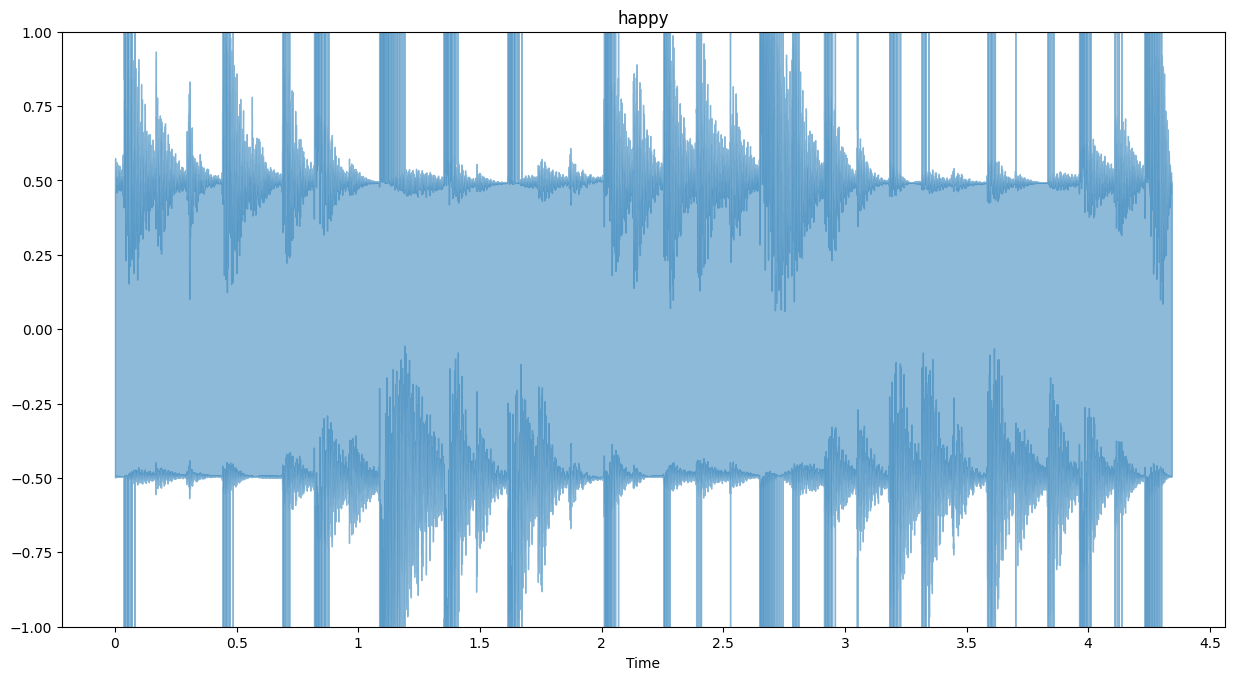

In [19]:
singal = xxx.reshape(-1,4).T

# YOUR CODE HERE
FRAME_SIZE = 1024
HOP_LENGTH = 512

frames = range(len(singal))
# t = librosa.frames_to_time(frames, hop_length=HOP_LENGTH)

import matplotlib.pyplot as plt
plt.figure(figsize=(15, 17))

ax = plt.subplot(2, 1, 1)
librosa.display.waveshow(singal, alpha=0.5)
# plt.plot(t, singal, color="r")
plt.ylim((-1, 1))
plt.title("happy")

In [20]:
# -*- coding: UTF-8 -*-
import torch
import numpy as np

class EmbeddingNetwork(torch.nn.Module):
    """The embedding network (encoder) for TimeGAN
    """
    def __init__(self, args):
        super(EmbeddingNetwork, self).__init__()
        self.feature_dim = args['feature_dim']
        self.hidden_dim = args['hidden_dim']
        self.num_layers = args['num_layers']
        self.padding_value = args['padding_value']
        self.max_seq_len = args['max_seq_len']

        # Embedder Architecture
        self.emb_rnn = torch.nn.GRU(
            input_size=self.feature_dim, 
            hidden_size=self.hidden_dim, 
            num_layers=self.num_layers, 
            batch_first=True
        )
        self.emb_linear = torch.nn.Linear(self.hidden_dim, self.hidden_dim)
        self.emb_sigmoid = torch.nn.Sigmoid()

        # Init weights
        # Default weights of TensorFlow is Xavier Uniform for W and 1 or 0 for b
        # Reference: 
        # - https://www.tensorflow.org/api_docs/python/tf/compat/v1/get_variable
        # - https://github.com/tensorflow/tensorflow/blob/v2.3.1/tensorflow/python/keras/layers/legacy_rnn/rnn_cell_impl.py#L484-L614
        with torch.no_grad():
            for name, param in self.emb_rnn.named_parameters():
                if 'weight_ih' in name:
                    torch.nn.init.xavier_uniform_(param.data)
                elif 'weight_hh' in name:
                    torch.nn.init.xavier_uniform_(param.data)
                elif 'bias_ih' in name:
                    param.data.fill_(1)
                elif 'bias_hh' in name:
                    param.data.fill_(0)
            for name, param in self.emb_linear.named_parameters():
                if 'weight' in name:
                    torch.nn.init.xavier_uniform_(param)
                elif 'bias' in name:
                    param.data.fill_(0)

    def forward(self, X, T):
        """Forward pass for embedding features from original space into latent space
        Args:
            - X: input time-series features (B x S x F)
            - T: input temporal information (B)
        Returns:
            - H: latent space embeddings (B x S x H)
        """
        # Dynamic RNN input for ignoring paddings
        X_packed = torch.nn.utils.rnn.pack_padded_sequence(
            input=X, 
            lengths=T, 
            batch_first=True, 
            enforce_sorted=False
        )
        
        # 128 x 100 x 71
        H_o, H_t = self.emb_rnn(X_packed)
        
        # Pad RNN output back to sequence length
        H_o, T = torch.nn.utils.rnn.pad_packed_sequence(
            sequence=H_o, 
            batch_first=True,
            padding_value=self.padding_value,
            total_length=self.max_seq_len
        )
        
        # 128 x 100 x 10
        logits = self.emb_linear(H_o)
        # 128 x 100 x 10
        H = self.emb_sigmoid(logits)
        return H

class RecoveryNetwork(torch.nn.Module):
    """The recovery network (decoder) for TimeGAN
    """
    def __init__(self, args):
        super(RecoveryNetwork, self).__init__()
        self.hidden_dim = args['hidden_dim']
        self.feature_dim = args['feature_dim']
        self.num_layers = args['num_layers']
        self.padding_value = args['padding_value']
        self.max_seq_len = args['max_seq_len']

        # Recovery Architecture
        self.rec_rnn = torch.nn.GRU(
            input_size=self.hidden_dim, 
            hidden_size=self.hidden_dim, 
            num_layers=self.num_layers, 
            batch_first=True
        )
        self.rec_linear = torch.nn.Linear(self.hidden_dim, self.feature_dim)

        # Init weights
        # Default weights of TensorFlow is Xavier Uniform for W and 1 or 0 for b
        # Reference: 
        # - https://www.tensorflow.org/api_docs/python/tf/compat/v1/get_variable
        # - https://github.com/tensorflow/tensorflow/blob/v2.3.1/tensorflow/python/keras/layers/legacy_rnn/rnn_cell_impl.py#L484-L614
        with torch.no_grad():
            for name, param in self.rec_rnn.named_parameters():
                if 'weight_ih' in name:
                    torch.nn.init.xavier_uniform_(param.data)
                elif 'weight_hh' in name:
                    torch.nn.init.xavier_uniform_(param.data)
                elif 'bias_ih' in name:
                    param.data.fill_(1)
                elif 'bias_hh' in name:
                    param.data.fill_(0)
            for name, param in self.rec_linear.named_parameters():
                if 'weight' in name:
                    torch.nn.init.xavier_uniform_(param)
                elif 'bias' in name:
                    param.data.fill_(0)

    def forward(self, H, T):
        """Forward pass for the recovering features from latent space to original space
        Args:
            - H: latent representation (B x S x E)
            - T: input temporal information (B)
        Returns:
            - X_tilde: recovered data (B x S x F)
        """
        # Dynamic RNN input for ignoring paddings
        H_packed = torch.nn.utils.rnn.pack_padded_sequence(
            input=H, 
            lengths=T, 
            batch_first=True, 
            enforce_sorted=False
        )
        
        # 128 x 100 x 10
        H_o, H_t = self.rec_rnn(H_packed)
        
        # Pad RNN output back to sequence length
        H_o, T = torch.nn.utils.rnn.pad_packed_sequence(
            sequence=H_o, 
            batch_first=True,
            padding_value=self.padding_value,
            total_length=self.max_seq_len
        )

        # 128 x 100 x 71
        X_tilde = self.rec_linear(H_o)
        return X_tilde

class SupervisorNetwork(torch.nn.Module):
    """The Supervisor network (decoder) for TimeGAN
    """
    def __init__(self, args):
        super(SupervisorNetwork, self).__init__()
        self.hidden_dim = args['hidden_dim']
        self.num_layers = args['num_layers']
        self.padding_value = args['padding_value']
        self.max_seq_len = args['max_seq_len']

        # Supervisor Architecture
        self.sup_rnn = torch.nn.GRU(
            input_size=self.hidden_dim, 
            hidden_size=self.hidden_dim, 
            num_layers=self.num_layers-1,
            batch_first=True
        )
        self.sup_linear = torch.nn.Linear(self.hidden_dim, self.hidden_dim)
        self.sup_sigmoid = torch.nn.Sigmoid()

        # Init weights
        # Default weights of TensorFlow is Xavier Uniform for W and 1 or 0 for b
        # Reference: 
        # - https://www.tensorflow.org/api_docs/python/tf/compat/v1/get_variable
        # - https://github.com/tensorflow/tensorflow/blob/v2.3.1/tensorflow/python/keras/layers/legacy_rnn/rnn_cell_impl.py#L484-L614
        with torch.no_grad():
            for name, param in self.sup_rnn.named_parameters():
                if 'weight_ih' in name:
                    torch.nn.init.xavier_uniform_(param.data)
                elif 'weight_hh' in name:
                    torch.nn.init.xavier_uniform_(param.data)
                elif 'bias_ih' in name:
                    param.data.fill_(1)
                elif 'bias_hh' in name:
                    param.data.fill_(0)
            for name, param in self.sup_linear.named_parameters():
                if 'weight' in name:
                    torch.nn.init.xavier_uniform_(param)
                elif 'bias' in name:
                    param.data.fill_(0)

    def forward(self, H, T):
        """Forward pass for the supervisor for predicting next step
        Args:
            - H: latent representation (B x S x E)
            - T: input temporal information (B)
        Returns:
            - H_hat: predicted next step data (B x S x E)
        """
        # Dynamic RNN input for ignoring paddings
        H_packed = torch.nn.utils.rnn.pack_padded_sequence(
            input=H, 
            lengths=T, 
            batch_first=True, 
            enforce_sorted=False
        )
        
        # 128 x 100 x 10
        H_o, H_t = self.sup_rnn(H_packed)
        
        # Pad RNN output back to sequence length
        H_o, T = torch.nn.utils.rnn.pad_packed_sequence(
            sequence=H_o, 
            batch_first=True,
            padding_value=self.padding_value,
            total_length=self.max_seq_len
        )

        # 128 x 100 x 10
        logits = self.sup_linear(H_o)
        # 128 x 100 x 10
        H_hat = self.sup_sigmoid(logits)
        return H_hat

class GeneratorNetwork(torch.nn.Module):
    """The generator network (encoder) for TimeGAN
    """
    def __init__(self, args):
        super(GeneratorNetwork, self).__init__()
        self.Z_dim = args['Z_dim']
        self.hidden_dim = args['hidden_dim']
        self.num_layers = args['num_layers']
        self.padding_value = args['padding_value']
        self.max_seq_len = args['max_seq_len']

        # Generator Architecture
        self.gen_rnn = torch.nn.GRU(
            input_size=self.Z_dim, 
            hidden_size=self.hidden_dim, 
            num_layers=self.num_layers, 
            batch_first=True
        )
        self.gen_linear = torch.nn.Linear(self.hidden_dim, self.hidden_dim)
        self.gen_sigmoid = torch.nn.Sigmoid()

        # Init weights
        # Default weights of TensorFlow is Xavier Uniform for W and 1 or 0 for b
        # Reference: 
        # - https://www.tensorflow.org/api_docs/python/tf/compat/v1/get_variable
        # - https://github.com/tensorflow/tensorflow/blob/v2.3.1/tensorflow/python/keras/layers/legacy_rnn/rnn_cell_impl.py#L484-L614
        with torch.no_grad():
            for name, param in self.gen_rnn.named_parameters():
                if 'weight_ih' in name:
                    torch.nn.init.xavier_uniform_(param.data)
                elif 'weight_hh' in name:
                    torch.nn.init.xavier_uniform_(param.data)
                elif 'bias_ih' in name:
                    param.data.fill_(1)
                elif 'bias_hh' in name:
                    param.data.fill_(0)
            for name, param in self.gen_linear.named_parameters():
                if 'weight' in name:
                    torch.nn.init.xavier_uniform_(param)
                elif 'bias' in name:
                    param.data.fill_(0)

    def forward(self, Z, T):
        """Takes in random noise (features) and generates synthetic features within the latent space
        Args:
            - Z: input random noise (B x S x Z)
            - T: input temporal information
        Returns:
            - H: embeddings (B x S x E)
        """
        # Dynamic RNN input for ignoring paddings
        Z_packed = torch.nn.utils.rnn.pack_padded_sequence(
            input=Z, 
            lengths=T, 
            batch_first=True, 
            enforce_sorted=False
        )
        
        # 128 x 100 x 71
        H_o, H_t = self.gen_rnn(Z_packed)
        
        # Pad RNN output back to sequence length
        H_o, T = torch.nn.utils.rnn.pad_packed_sequence(
            sequence=H_o, 
            batch_first=True,
            padding_value=self.padding_value,
            total_length=self.max_seq_len
        )

        # 128 x 100 x 10
        logits = self.gen_linear(H_o)
        # B x S
        H = self.gen_sigmoid(logits)
        return H

class DiscriminatorNetwork(torch.nn.Module):
    """The Discriminator network (decoder) for TimeGAN
    """
    def __init__(self, args):
        super(DiscriminatorNetwork, self).__init__()
        self.hidden_dim = args['hidden_dim']
        self.num_layers = args['num_layers']
        self.padding_value = args['padding_value']
        self.max_seq_len = args['max_seq_len']

        # Discriminator Architecture
        self.dis_rnn = torch.nn.GRU(
            input_size=self.hidden_dim, 
            hidden_size=self.hidden_dim, 
            num_layers=self.num_layers, 
            batch_first=True
        )
        self.dis_linear = torch.nn.Linear(self.hidden_dim, 1)

        # Init weights
        # Default weights of TensorFlow is Xavier Uniform for W and 1 or 0 for b
        # Reference: 
        # - https://www.tensorflow.org/api_docs/python/tf/compat/v1/get_variable
        # - https://github.com/tensorflow/tensorflow/blob/v2.3.1/tensorflow/python/keras/layers/legacy_rnn/rnn_cell_impl.py#L484-L614
        with torch.no_grad():
            for name, param in self.dis_rnn.named_parameters():
                if 'weight_ih' in name:
                    torch.nn.init.xavier_uniform_(param.data)
                elif 'weight_hh' in name:
                    torch.nn.init.xavier_uniform_(param.data)
                elif 'bias_ih' in name:
                    param.data.fill_(1)
                elif 'bias_hh' in name:
                    param.data.fill_(0)
            for name, param in self.dis_linear.named_parameters():
                if 'weight' in name:
                    torch.nn.init.xavier_uniform_(param)
                elif 'bias' in name:
                    param.data.fill_(0)

    def forward(self, H, T):
        """Forward pass for predicting if the data is real or synthetic
        Args:
            - H: latent representation (B x S x E)
            - T: input temporal information
        Returns:
            - logits: predicted logits (B x S x 1)
        """
        # Dynamic RNN input for ignoring paddings
        H_packed = torch.nn.utils.rnn.pack_padded_sequence(
            input=H, 
            lengths=T, 
            batch_first=True, 
            enforce_sorted=False
        )
        
        # 128 x 100 x 10
        H_o, H_t = self.dis_rnn(H_packed)
        
        # Pad RNN output back to sequence length
        H_o, T = torch.nn.utils.rnn.pad_packed_sequence(
            sequence=H_o, 
            batch_first=True,
            padding_value=self.padding_value,
            total_length=self.max_seq_len
        )

        # 128 x 100
        logits = self.dis_linear(H_o).squeeze(-1)
        return logits

class TimeGAN(torch.nn.Module):
    """Implementation of TimeGAN (Yoon et al., 2019) using PyTorch
    Reference:
    - https://papers.nips.cc/paper/2019/hash/c9efe5f26cd17ba6216bbe2a7d26d490-Abstract.html
    - https://github.com/jsyoon0823/TimeGAN
    """
    def __init__(self, args):
        super(TimeGAN, self).__init__()
        self.device = args['device']
        self.feature_dim = args['feature_dim']
        self.Z_dim = args['Z_dim']
        self.hidden_dim = args['hidden_dim']
        self.max_seq_len = args['max_seq_len']
        self.batch_size = args['batch_size']

        self.embedder = EmbeddingNetwork(args)
        self.recovery = RecoveryNetwork(args)
        self.generator = GeneratorNetwork(args)
        self.supervisor = SupervisorNetwork(args)
        self.discriminator = DiscriminatorNetwork(args)

    def _recovery_forward(self, X, T):
        """The embedding network forward pass and the embedder network loss
        Args:
            - X: the original input features
            - T: the temporal information
        Returns:
            - E_loss: the reconstruction loss
            - X_tilde: the reconstructed features
        """
        # Forward Pass
        H = self.embedder(X, T)
        X_tilde = self.recovery(H, T)

        # For Joint training
        H_hat_supervise = self.supervisor(H, T)
        G_loss_S = torch.nn.functional.mse_loss(
            H_hat_supervise[:,:-1,:], 
            H[:,1:,:]
        ) # Teacher forcing next output

        # Reconstruction Loss
        E_loss_T0 = torch.nn.functional.mse_loss(X_tilde, X)
        E_loss0 = 10 * torch.sqrt(E_loss_T0)
        E_loss = E_loss0 + 0.1 * G_loss_S
        return E_loss, E_loss0, E_loss_T0

    def _supervisor_forward(self, X, T):
        """The supervisor training forward pass
        Args:
            - X: the original feature input
        Returns:
            - S_loss: the supervisor's loss
        """
        # Supervision Forward Pass
        H = self.embedder(X, T)
        H_hat_supervise = self.supervisor(H, T)

        # Supervised loss
        S_loss = torch.nn.functional.mse_loss(H_hat_supervise[:,:-1,:], H[:,1:,:])        # Teacher forcing next output
        return S_loss

    def _discriminator_forward(self, X, T, Z, gamma=1):
        """The discriminator forward pass and adversarial loss
        Args:
            - X: the input features
            - T: the temporal information
            - Z: the input noise
        Returns:
            - D_loss: the adversarial loss
        """
        # Real
        H = self.embedder(X, T).detach()
        
        # Generator
        E_hat = self.generator(Z, T).detach()
        H_hat = self.supervisor(E_hat, T).detach()

        # Forward Pass
        Y_real = self.discriminator(H, T)            # Encoded original data
        Y_fake = self.discriminator(H_hat, T)        # Output of generator + supervisor
        Y_fake_e = self.discriminator(E_hat, T)      # Output of generator

        D_loss_real = torch.nn.functional.binary_cross_entropy_with_logits(Y_real, torch.ones_like(Y_real))
        D_loss_fake = torch.nn.functional.binary_cross_entropy_with_logits(Y_fake, torch.zeros_like(Y_fake))
        D_loss_fake_e = torch.nn.functional.binary_cross_entropy_with_logits(Y_fake_e, torch.zeros_like(Y_fake_e))

        D_loss = D_loss_real + D_loss_fake + gamma * D_loss_fake_e

        return D_loss

    def _generator_forward(self, X, T, Z, gamma=1):
        """The generator forward pass
        Args:
            - X: the original feature input
            - T: the temporal information
            - Z: the noise for generator input
        Returns:
            - G_loss: the generator's loss
        """
        # Supervisor Forward Pass
        H = self.embedder(X, T)
        H_hat_supervise = self.supervisor(H, T)

        # Generator Forward Pass
        E_hat = self.generator(Z, T)
        H_hat = self.supervisor(E_hat, T)

        # Synthetic data generated
        X_hat = self.recovery(H_hat, T)

        # Generator Loss
        # 1. Adversarial loss
        Y_fake = self.discriminator(H_hat, T)        # Output of supervisor
        Y_fake_e = self.discriminator(E_hat, T)      # Output of generator

        G_loss_U = torch.nn.functional.binary_cross_entropy_with_logits(Y_fake, torch.ones_like(Y_fake))
        G_loss_U_e = torch.nn.functional.binary_cross_entropy_with_logits(Y_fake_e, torch.ones_like(Y_fake_e))

        # 2. Supervised loss
        G_loss_S = torch.nn.functional.mse_loss(H_hat_supervise[:,:-1,:], H[:,1:,:])        # Teacher forcing next output

        # 3. Two Momments
        G_loss_V1 = torch.mean(torch.abs(torch.sqrt(X_hat.var(dim=0, unbiased=False) + 1e-6) - torch.sqrt(X.var(dim=0, unbiased=False) + 1e-6)))
        G_loss_V2 = torch.mean(torch.abs((X_hat.mean(dim=0)) - (X.mean(dim=0))))

        G_loss_V = G_loss_V1 + G_loss_V2

        # 4. Summation
        G_loss = G_loss_U + gamma * G_loss_U_e + 100 * torch.sqrt(G_loss_S) + 100 * G_loss_V

        return G_loss

    def _inference(self, Z, T):
        """Inference for generating synthetic data
        Args:
            - Z: the input noise
            - T: the temporal information
        Returns:
            - X_hat: the generated data
        """
        # Generator Forward Pass
        E_hat = self.generator(Z, T)
        H_hat = self.supervisor(E_hat, T)

        # Synthetic data generated
        X_hat = self.recovery(H_hat, T)
        return X_hat

    def forward(self, X, T, Z, obj, gamma=1):
        """
        Args:
            - X: the input features (B, H, F)
            - T: the temporal information (B)
            - Z: the sampled noise (B, H, Z)
            - obj: the network to be trained (`autoencoder`, `supervisor`, `generator`, `discriminator`)
            - gamma: loss hyperparameter
        Returns:
            - loss: The loss for the forward pass
            - X_hat: The generated data
        """
        if obj != "inference":
            if X is None:
                raise ValueError("`X` should be given")

            X = torch.FloatTensor(X)
            X = X.to(self.device)

        if Z is not None:
            Z = torch.FloatTensor(Z)
            Z = Z.to(self.device)

        if obj == "autoencoder":
            # Embedder & Recovery
            loss = self._recovery_forward(X, T)

        elif obj == "supervisor":
            # Supervisor
            loss = self._supervisor_forward(X, T)

        elif obj == "generator":
            if Z is None:
                raise ValueError("`Z` is not given")

            # Generator
            loss = self._generator_forward(X, T, Z)

        elif obj == "discriminator":
            if Z is None:
                raise ValueError("`Z` is not given")
            
            # Discriminator
            loss = self._discriminator_forward(X, T, Z)
            
            return loss

        elif obj == "inference":

            X_hat = self._inference(Z, T)
            X_hat = X_hat.cpu().detach()

            return X_hat

        else: raise ValueError("`obj` should be either `autoencoder`, `supervisor`, `generator`, or `discriminator`")

        return loss

In [21]:
# -*- coding: UTF-8 -*-
import numpy as np
import torch

class TimeGANDataset(torch.utils.data.Dataset):
    """TimeGAN Dataset for sampling data with their respective time

    Args:
        - data (numpy.ndarray): the padded dataset to be fitted (D x S x F)
        - time (numpy.ndarray): the length of each data (D)
    Parameters:
        - x (torch.FloatTensor): the real value features of the data
        - t (torch.LongTensor): the temporal feature of the data 
    """
    def __init__(self, data, time=None, padding_value=None):
        # sanity check
        if len(data) != len(time):
            raise ValueError(
                f"len(data) `{len(data)}` != len(time) {len(time)}"
            )

        if isinstance(time, type(None)):
            time = [len(x) for x in data]

        self.X = torch.FloatTensor(data)
        self.T = torch.LongTensor(time)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.T[idx]

    def collate_fn(self, batch):
        """Minibatch sampling
        """
        # Pad sequences to max length
        X_mb = [X for X in batch[0]]
        
        # The actual length of each data
        T_mb = [T for T in batch[1]]
        
        return X_mb, T_mb

In [22]:
# -*- coding: UTF-8 -*-
# Local modules
import os
import pickle
from typing import Dict, Union

# 3rd party modules
import numpy as np
from tqdm import tqdm, trange

import torch
from torch.utils.tensorboard import SummaryWriter

# Self-written modules

def embedding_trainer(
    model: torch.nn.Module, 
    dataloader: torch.utils.data.DataLoader, 
    e_opt: torch.optim.Optimizer, 
    r_opt: torch.optim.Optimizer, 
    args: Dict, 
    writer: Union[torch.utils.tensorboard.SummaryWriter, type(None)]=None
) -> None:
    """The training loop for the embedding and recovery functions
    """  
    logger = trange(args['emb_epochs'], desc=f"Epoch: 0, Loss: 0")
    for epoch in logger:   
        for X_mb, T_mb in dataloader:
            # Reset gradients
            model.zero_grad()

            # Forward Pass
            # time = [args['max_seq_len'] for _ in range(len(T_mb))]
            _, E_loss0, E_loss_T0 = model(X=X_mb, T=T_mb, Z=None, obj="autoencoder")
            loss = np.sqrt(E_loss_T0.item())

            # Backward Pass
            E_loss0.backward()

            # Update model parameters
            e_opt.step()
            r_opt.step()

        # Log loss for final batch of each epoch (29 iters)
        logger.set_description(f"Epoch: {epoch}, Loss: {loss:.4f}")
        if writer:
            writer.add_scalar(
                "Embedding/Loss:", 
                loss, 
                epoch
            )
            writer.flush()

def supervisor_trainer(
    model: torch.nn.Module, 
    dataloader: torch.utils.data.DataLoader, 
    s_opt: torch.optim.Optimizer, 
    g_opt: torch.optim.Optimizer, 
    args: Dict, 
    writer: Union[torch.utils.tensorboard.SummaryWriter, type(None)]=None
) -> None:
    """The training loop for the supervisor function
    """
    logger = trange(args['sup_epochs'], desc=f"Epoch: 0, Loss: 0")
    for epoch in logger:
        for X_mb, T_mb in dataloader:
            # Reset gradients
            model.zero_grad()

            # Forward Pass
            S_loss = model(X=X_mb, T=T_mb, Z=None, obj="supervisor")

            # Backward Pass
            S_loss.backward()
            loss = np.sqrt(S_loss.item())

            # Update model parameters
            s_opt.step()

        # Log loss for final batch of each epoch (29 iters)
        logger.set_description(f"Epoch: {epoch}, Loss: {loss:.4f}")
        if writer:
            writer.add_scalar(
                "Supervisor/Loss:", 
                loss, 
                epoch
            )
            writer.flush()

def joint_trainer(
    model: torch.nn.Module, 
    dataloader: torch.utils.data.DataLoader, 
    e_opt: torch.optim.Optimizer, 
    r_opt: torch.optim.Optimizer, 
    s_opt: torch.optim.Optimizer, 
    g_opt: torch.optim.Optimizer, 
    d_opt: torch.optim.Optimizer, 
    args: Dict, 
    writer: Union[torch.utils.tensorboard.SummaryWriter, type(None)]=None, 
) -> None:
    """The training loop for training the model altogether
    """
    logger = trange(
        args['sup_epochs'], 
        desc=f"Epoch: 0, E_loss: 0, G_loss: 0, D_loss: 0"
    )
    
    for epoch in logger:
        for X_mb, T_mb in dataloader:
            ## Generator Training
            for _ in range(2):
                # Random Generator
                Z_mb = torch.rand((args['batch_size'], args['max_seq_len'], args['Z_dim']))

                # Forward Pass (Generator)
                model.zero_grad()
                G_loss = model(X=X_mb, T=T_mb, Z=Z_mb, obj="generator")
                G_loss.backward()
                G_loss = np.sqrt(G_loss.item())

                # Update model parameters
                g_opt.step()
                s_opt.step()

                # Forward Pass (Embedding)
                model.zero_grad()
                E_loss, _, E_loss_T0 = model(X=X_mb, T=T_mb, Z=Z_mb, obj="autoencoder")
                E_loss.backward()
                E_loss = np.sqrt(E_loss.item())
                
                # Update model parameters
                e_opt.step()
                r_opt.step()

            # Random Generator
            Z_mb = torch.rand((args['batch_size'], args['max_seq_len'], args['Z_dim']))

            ## Discriminator Training
            model.zero_grad()
            # Forward Pass
            D_loss = model(X=X_mb, T=T_mb, Z=Z_mb, obj="discriminator")

            # Check Discriminator loss
            if D_loss > args['dis_thresh']:
                # Backward Pass
                D_loss.backward()

                # Update model parameters
                d_opt.step()
            D_loss = D_loss.item()

        logger.set_description(
            f"Epoch: {epoch}, E: {E_loss:.4f}, G: {G_loss:.4f}, D: {D_loss:.4f}"
        )
        if writer:
            writer.add_scalar(
                'Joint/Embedding_Loss:', 
                E_loss, 
                epoch
            )
            writer.add_scalar(
                'Joint/Generator_Loss:', 
                G_loss, 
                epoch
            )
            writer.add_scalar(
                'Joint/Discriminator_Loss:', 
                D_loss, 
                epoch
            )
            writer.flush()

def timegan_trainer(model, data, time, args):
    """The training procedure for TimeGAN
    Args:
        - model (torch.nn.module): The model model that generates synthetic data
        - data (numpy.ndarray): The data for training the model
        - time (numpy.ndarray): The time for the model to be conditioned on
        - args (dict): The model/training configurations
    Returns:
        - generated_data (np.ndarray): The synthetic data generated by the model
    """

    # Initialize TimeGAN dataset and dataloader
    dataset = TimeGANDataset(data, time)
    dataloader = torch.utils.data.DataLoader(
        dataset=dataset,
        batch_size=args['batch_size'],
        shuffle=False    
    )

    model.to(args['device'])

    # Initialize Optimizers
    e_opt = torch.optim.Adam(model.embedder.parameters(), lr=args['learning_rate'])
    r_opt = torch.optim.Adam(model.recovery.parameters(), lr=args['learning_rate'])
    s_opt = torch.optim.Adam(model.supervisor.parameters(), lr=args['learning_rate'])
    g_opt = torch.optim.Adam(model.generator.parameters(), lr=args['learning_rate'])
    d_opt = torch.optim.Adam(model.discriminator.parameters(), lr=args['learning_rate'])
    
    # TensorBoard writer
    writer = SummaryWriter(os.path.join(f"tensorboard/{args['exp']}"))

    print("\nStart Embedding Network Training")
    embedding_trainer(
        model=model, 
        dataloader=dataloader, 
        e_opt=e_opt, 
        r_opt=r_opt, 
        args=args, 
        writer=writer
    )

    print("\nStart Training with Supervised Loss Only")
    supervisor_trainer(
        model=model,
        dataloader=dataloader,
        s_opt=s_opt,
        g_opt=g_opt,
        args=args,
        writer=writer
    )

    print("\nStart Joint Training")
    joint_trainer(
        model=model,
        dataloader=dataloader,
        e_opt=e_opt,
        r_opt=r_opt,
        s_opt=s_opt,
        g_opt=g_opt,
        d_opt=d_opt,
        args=args,
        writer=writer,
    )

    # Save model, args, and hyperparameters
    torch.save(args, f"{args['model_path']}/args['pickle']")
    torch.save(model.state_dict(), f"{args['model_path']}/model.pt")
    print(f"\nSaved at path: {args['model_path']}")

def timegan_generator(model, T, args):
    """The inference procedure for TimeGAN
    Args:
        - model (torch.nn.module): The model model that generates synthetic data
        - T (List[int]): The time to be generated on
        - args (dict): The model/training configurations
    Returns:
        - generated_data (np.ndarray): The synthetic data generated by the model
    """
    # Load model for inference
    if not os.path.exists(args['model_path']):
        raise ValueError(f"Model directory not found...")

    # Load arguments and model
    with open(f"{args['model_path']}/args['pickle']", "rb") as fb:
        args = torch.load(fb)
    
    model.load_state_dict(torch.load(f"{args['model_path']}/model.pt"))
    
    print("\nGenerating Data...")
    # Initialize model to evaluation mode and run without gradients
    model.to(args['device'])
    model.eval()
    with torch.no_grad():
        # Generate fake data
        Z = torch.rand((len(T), args['max_seq_len'], args['Z_dim']))
        
        generated_data = model(X=None, T=T, Z=Z, obj="inference")

    return generated_data.numpy()

In [23]:
#########################
# Initialize and Run model
#########################

# Log start time
start = time.time()
model = TimeGAN(args)
if args['is_train'] == True:
#     timegan_trainer(model, train_data, train_time, args)
    timegan_trainer(model, X, T, args)    
generated_data = timegan_generator(model, T, args)
generated_time = train_time
# Log end time
end = time.time()


Start Embedding Network Training


Epoch: 599, Loss: 0.0028: 100%|██████████| 600/600 [04:47<00:00,  2.09it/s]



Start Training with Supervised Loss Only


Epoch: 599, Loss: 0.0083: 100%|██████████| 600/600 [03:44<00:00,  2.67it/s]



Start Joint Training


Epoch: 599, E: 0.2157, G: 2.0094, D: 1.9119: 100%|██████████| 600/600 [41:59<00:00,  4.20s/it]


Saved at path: /kaggle/working/output/test

Generating Data...


In [24]:
print(f"Generated data preview:\n{generated_data[:2, -10:, :2]}\n")
print(f"Model Runtime: {(end - start)/60} mins\n")

#########################
# Save train and generated data for visualization
#########################

# Save splitted data and generated data
with open(f"{args['model_path']}/train_data.pickle", "wb") as fb:
    pickle.dump(train_data, fb)
with open(f"{args['model_path']}/train_time.pickle", "wb") as fb:
    pickle.dump(train_time, fb)
with open(f"{args['model_path']}/test_data.pickle", "wb") as fb:
    pickle.dump(test_data, fb)
with open(f"{args['model_path']}/test_time.pickle", "wb") as fb:
    pickle.dump(test_time, fb)
with open(f"{args['model_path']}/fake_data.pickle", "wb") as fb:
    pickle.dump(generated_data, fb)
with open(f"{args['model_path']}/fake_time.pickle", "wb") as fb:
    pickle.dump(generated_time, fb)

Generated data preview:
[[[-1.0012572 -0.9991451]
  [-1.0012572 -0.9991451]
  [-1.0012572 -0.9991451]
  [-1.0012572 -0.9991451]
  [-1.0012572 -0.9991451]
  [-1.0012572 -0.9991451]
  [-1.0012572 -0.9991451]
  [-1.0012572 -0.9991451]
  [-1.0012572 -0.9991451]
  [-1.0012572 -0.9991451]]

 [[-1.0012572 -0.9991451]
  [-1.0012572 -0.9991451]
  [-1.0012572 -0.9991451]
  [-1.0012572 -0.9991451]
  [-1.0012572 -0.9991451]
  [-1.0012572 -0.9991451]
  [-1.0012572 -0.9991451]
  [-1.0012572 -0.9991451]
  [-1.0012572 -0.9991451]
  [-1.0012572 -0.9991451]]]

Model Runtime: 50.58998475869497 mins



In [25]:
import numpy as np
import torch

class FeaturePredictionDataset(torch.utils.data.Dataset):
    r"""The dataset for predicting the feature of `idx` given the other features
    Args:
    - data (np.ndarray): the dataset to be trained on (B x S x F)
    - idx (int): the index of the feature to be predicted
    """
    def __init__(self, data, time, idx):
        no, seq_len, dim = data.shape
        self.X = torch.FloatTensor(
            np.concatenate(
                (data[:, :, :idx], data[:, :, (idx+1):]), 
                axis=2
            )
        )
        self.T = torch.LongTensor(time)
        self.Y = torch.FloatTensor(np.reshape(data[:, :, idx], [no, seq_len, 1]))

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.T[idx], self.Y[idx]

class OneStepPredictionDataset(torch.utils.data.Dataset):
    r"""The dataset for predicting the feature of `idx` given the other features
    Args:
    - data (np.ndarray): the dataset to be trained on (B x S x F)
    """
    def __init__(self, data, time):
        self.X = torch.FloatTensor(data[:, :-1, :])
        self.T = torch.LongTensor([t-1 if t == 100 else t for t in time])
        self.Y = torch.FloatTensor(data[:, 1:, :])

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.T[idx], self.Y[idx]

In [26]:
import torch

class GeneralRNN(torch.nn.Module):
    r"""A general RNN model for time-series prediction
    """
    def __init__(self, args):
        super(GeneralRNN, self).__init__()
        self.model_type = args['model_type']

        self.input_size = args['in_dim']
        self.hidden_size = args['h_dim']
        self.output_size = args['out_dim']
        self.num_layers = args['n_layers']
        self.dropout = args['dropout']
        self.bidirectional = args['bidirectional']

        self.padding_value = args['padding_value']
        self.max_seq_len = args['max_seq_len']
    
        self.rnn_module = self._get_rnn_module(self.model_type)
        
        self.rnn_layer = self.rnn_module(
            input_size=self.input_size, 
            hidden_size=self.hidden_size,
            num_layers=self.num_layers,
            batch_first=True,
            dropout=self.dropout,
            bidirectional=self.bidirectional
        )
        
        self.linear_layer = torch.nn.Linear(
            in_features=self.hidden_size,
            out_features=self.output_size
        )

    def _get_rnn_module(self, model_type):
        if model_type == "rnn":
            return torch.nn.RNN
        elif model_type == "lstm":
            return torch.nn.LSTM
        elif model_type == "gru":
            return torch.nn.GRU

    def forward(self, X, T):
        # Dynamic RNN input for ignoring paddings
        X_packed = torch.nn.utils.rnn.pack_padded_sequence(
            input=X, 
            lengths=T, 
            batch_first=True, 
            enforce_sorted=False
        )

        H_o, H_t = self.rnn_layer(X_packed)
        
        # Pad RNN output back to sequence length
        H_o, T = torch.nn.utils.rnn.pad_packed_sequence(
            sequence=H_o, 
            batch_first=True,
            padding_value=self.padding_value,
            total_length=self.max_seq_len
        )
        
        logits = self.linear_layer(H_o)
        return logits

In [27]:
# Necessary packages
import torch
from tqdm import tqdm, trange
import numpy as np
from sklearn.metrics import accuracy_score, mean_squared_error


def rmse_error(y_true, y_pred):
    """User defined root mean squared error.

    Args:
    - y_true: true labels
    - y_pred: predictions

    Returns:
    - computed_rmse: computed rmse loss
    """
    # Exclude masked labels
    idx = (y_true >= 0) * 1
    # Mean squared loss excluding masked labels
    computed_mse = np.sum(idx * ((y_true - y_pred)**2)) / np.sum(idx)
    computed_rmse = np.sqrt(computed_mse)
    return computed_rmse

def reidentify_score(enlarge_label, pred_label):
    """Return the reidentification score.

    Args:
    - enlarge_label: 1 for train data, 0 for other data
    - pred_label: 1 for reidentified data, 0 for not reidentified data

    Returns:
    - accuracy: reidentification score
    """  
    accuracy = accuracy_score(enlarge_label, pred_label > 0.5)  
    return accuracy

def feature_prediction(train_data, test_data, index):
    """Use the other features to predict a certain feature.

    Args:
    - train_data (train_data, train_time): training time-series
    - test_data (test_data, test_data): testing time-series
    - index: feature index to be predicted

    Returns:
    - perf: average performance of feature predictions (in terms of AUC or MSE)
    """
    train_data, train_time = train_data
    test_data, test_time = test_data

    # Parameters
    no, seq_len, dim = train_data.shape

    # Set model parameters

    args = {}
    args["device"] = "cuda"
    args["task"] = "regression"
    args["model_type"] = "gru"
    args["bidirectional"] = False
    args["epochs"] = 20
    args["batch_size"] = 128
    args["in_dim"] = dim-1
    args["h_dim"] = dim-1
    args["out_dim"] = 1
    args["n_layers"] = 3
    args["dropout"] = 0.5
    args["padding_value"] = -1.0
    args["max_seq_len"] = 100
    args["learning_rate"] = 1e-3
    args["grad_clip_norm"] = 5.0

    # Output initialization
    perf = list()
  
    # For each index
    for idx in index:
        # Set training features and labels
        train_dataset = FeaturePredictionDataset(
            train_data, 
            train_time, 
            idx
        )
        train_dataloader = torch.utils.data.DataLoader(
            train_dataset,
            batch_size=args["batch_size"],
            shuffle=True
        )

        # Set testing features and labels
        test_dataset = FeaturePredictionDataset(
            test_data, 
            test_time,
            idx
        )
        test_dataloader = torch.utils.data.DataLoader(
            test_dataset,
            batch_size=no,
            shuffle=False
        )

        # Initialize model
        model = GeneralRNN(args)
        model.to(args["device"])
        criterion = torch.nn.MSELoss()
        optimizer = torch.optim.Adam(
            model.parameters(),
            lr=args["learning_rate"]
        )

        logger = trange(args["epochs"], desc=f"Epoch: 0, Loss: 0")
        for epoch in logger:
            running_loss = 0.0

            for train_x, train_t, train_y in train_dataloader:
                train_x = train_x.to(args["device"])
                train_y = train_y.to(args["device"])
                # zero the parameter gradients
                optimizer.zero_grad()
                # forward
                train_p = model(train_x, train_t)
                loss = criterion(train_p, train_y)
                # backward
                loss.backward()
                # optimize
                optimizer.step()

                running_loss += loss.item()

            logger.set_description(f"Epoch: {epoch}, Loss: {running_loss:.4f}")

        
        # Evaluate the trained model
        with torch.no_grad():
            temp_perf = 0
            for test_x, test_t, test_y in test_dataloader:
                test_x = test_x.to(args["device"])
                test_p = model(test_x, test_t).cpu().numpy()

                test_p = np.reshape(test_p, [-1])
                test_y = np.reshape(test_y.numpy(), [-1])
        
                temp_perf = rmse_error(test_y, test_p)
      
        perf.append(temp_perf)
    
    return perf
      
def one_step_ahead_prediction(train_data, test_data):
    """Use the previous time-series to predict one-step ahead feature values.

    Args:
    - train_data: training time-series
    - test_data: testing time-series

    Returns:
    - perf: average performance of one-step ahead predictions (in terms of AUC or MSE)
    """
    train_data, train_time = train_data
    test_data, test_time = test_data
    
    # Parameters
    no, seq_len, dim = train_data.shape

    # Set model parameters
    args = {}
    args["device"] = "cuda"
    args["task"] = "regression"
    args["model_type"] = "gru"
    args["bidirectional"] = False
    args["epochs"] = 20
    args["batch_size"] = 128
    args["in_dim"] = dim
    args["h_dim"] = dim
    args["out_dim"] = dim
    args["n_layers"] = 3
    args["dropout"] = 0.5
    args["padding_value"] = -1.0
    args["max_seq_len"] = 100 - 1   # only 99 is used for prediction
    args["learning_rate"] = 1e-3
    args["grad_clip_norm"] = 5.0

    # Set training features and labels
    train_dataset = OneStepPredictionDataset(train_data, train_time)
    train_dataloader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=args["batch_size"],
        shuffle=True
    )

    # Set testing features and labels
    test_dataset = OneStepPredictionDataset(test_data, test_time)
    test_dataloader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=no,
        shuffle=True
    )
    # Initialize model
    model = GeneralRNN(args)
    model.to(args["device"])
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(
        model.parameters(), 
        lr=args["learning_rate"]
    )

    # Train the predictive model
    logger = trange(args["epochs"], desc=f"Epoch: 0, Loss: 0")
    for epoch in logger:
        running_loss = 0.0

        for train_x, train_t, train_y in train_dataloader:
            train_x = train_x.to(args["device"])
            train_y = train_y.to(args["device"])
            # zero the parameter gradients
            optimizer.zero_grad()
            # forward
            train_p = model(train_x, train_t)
            loss = criterion(train_p, train_y)
            # backward
            loss.backward()
            # optimize
            optimizer.step()

            running_loss += loss.item()

        logger.set_description(f"Epoch: {epoch}, Loss: {running_loss:.4f}")

    # Evaluate the trained model
    with torch.no_grad():
        perf = 0
        for test_x, test_t, test_y in test_dataloader:
            test_x = test_x.to(args["device"])
            test_p = model(test_x, test_t).cpu()

            test_p = np.reshape(test_p.numpy(), [-1])
            test_y = np.reshape(test_y.numpy(), [-1])

            perf += rmse_error(test_y, test_p)

    return perf

In [28]:
# Necessary packages
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

   
def visualization(ori_data, generated_data, analysis):
  """Using PCA or tSNE for generated and original data visualization.
  
  Args:
    - ori_data: original data
    - generated_data: generated synthetic data
    - analysis: tsne or pca
  """  
  # Analysis sample size (for faster computation)
  anal_sample_no = min([1000, len(ori_data)])
  idx = np.random.permutation(len(ori_data))[:anal_sample_no]
    
  # Data preprocessing
  ori_data = np.asarray(ori_data)
  generated_data = np.asarray(generated_data)  
  
  ori_data = ori_data[idx]
  generated_data = generated_data[idx]
  
  no, seq_len, dim = ori_data.shape  
  
  for i in range(anal_sample_no):
    if (i == 0):
      prep_data = np.reshape(np.mean(ori_data[0,:,:], 1), [1,seq_len])
      prep_data_hat = np.reshape(np.mean(generated_data[0,:,:],1), [1,seq_len])
    else:
      prep_data = np.concatenate((prep_data, 
                                  np.reshape(np.mean(ori_data[i,:,:],1), [1,seq_len])))
      prep_data_hat = np.concatenate((prep_data_hat, 
                                      np.reshape(np.mean(generated_data[i,:,:],1), [1,seq_len])))
    
  # Visualization parameter        
  colors = ["tab:blue" for i in range(anal_sample_no)] + ["tab:orange" for i in range(anal_sample_no)]    
    
  if analysis == 'pca':
    # PCA Analysis
    pca = PCA(n_components = 2)
    pca.fit(prep_data)
    pca_results = pca.transform(prep_data)
    pca_hat_results = pca.transform(prep_data_hat)
    
    # Plotting
    f, ax = plt.subplots(1)    
    plt.scatter(pca_results[:,0], pca_results[:,1],
                c = colors[:anal_sample_no], alpha = 0.2, label = "Original")
    plt.scatter(pca_hat_results[:,0], pca_hat_results[:,1], 
                c = colors[anal_sample_no:], alpha = 0.2, label = "Synthetic")
  
    ax.legend()
    plt.title('PCA plot')
    plt.xlabel('x-pca')
    plt.ylabel('y_pca')
    plt.show()
    
  elif analysis == 'tsne':
    
    # Do t-SNE Analysis together       
    prep_data_final = np.concatenate((prep_data, prep_data_hat), axis = 0)
    
    # TSNE anlaysis
    tsne = TSNE(n_components = 2, verbose = 1, perplexity = 40, n_iter = 300)
    tsne_results = tsne.fit_transform(prep_data_final)
      
    # Plotting
    f, ax = plt.subplots(1)
      
    plt.scatter(tsne_results[:anal_sample_no,0], tsne_results[:anal_sample_no,1], 
                c = colors[:anal_sample_no], alpha = 0.2, label = "Original")
    plt.scatter(tsne_results[anal_sample_no:,0], tsne_results[anal_sample_no:,1], 
                c = colors[anal_sample_no:], alpha = 0.2, label = "Synthetic")
  
    ax.legend()
      
    plt.title('t-SNE plot')
    plt.xlabel('x-tsne')
    plt.ylabel('y_tsne')
    plt.show()

In [29]:
with open(f"/kaggle/working/output/test/fake_data.pickle", "rb") as fb:
    generated_data = pickle.load(fb)
    
with open(f"/kaggle/working/output/test/fake_time.pickle", "rb") as fb:
    generated_time = pickle.load(fb)

In [31]:
path = "/kaggle/working/output/test"

with open(f"{path}/train_data.pickle", "rb") as fb:
    ori_data = pickle.load(fb)
    # ori_data = ori_data.reshape(ori_data.shape[0]*ori_data.shape[1], ori_data.shape[2])
with open(f"{path}/fake_data.pickle", "rb") as fb:
    new_data = pickle.load(fb)

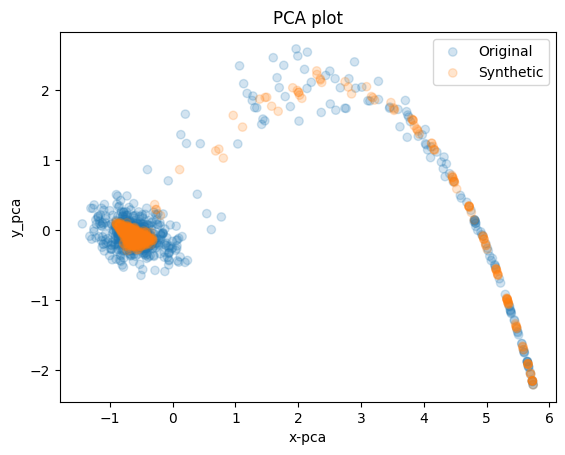

In [32]:
visualization(ori_data, new_data, 'pca')

In [34]:
new_data.shape

(3991, 100, 4)

In [35]:
new_dataxxx = new_data[:, :24, :]
new_dataxxx.T.shape

(4, 24, 3991)

In [36]:
ipd.Audio(new_dataxxx.reshape(-1,4).T, rate=sample_rate)

In [37]:
ipd.Audio(xxx.reshape(-1,4).T, rate=sample_rate)

Text(0.5, 1.0, 'happy')

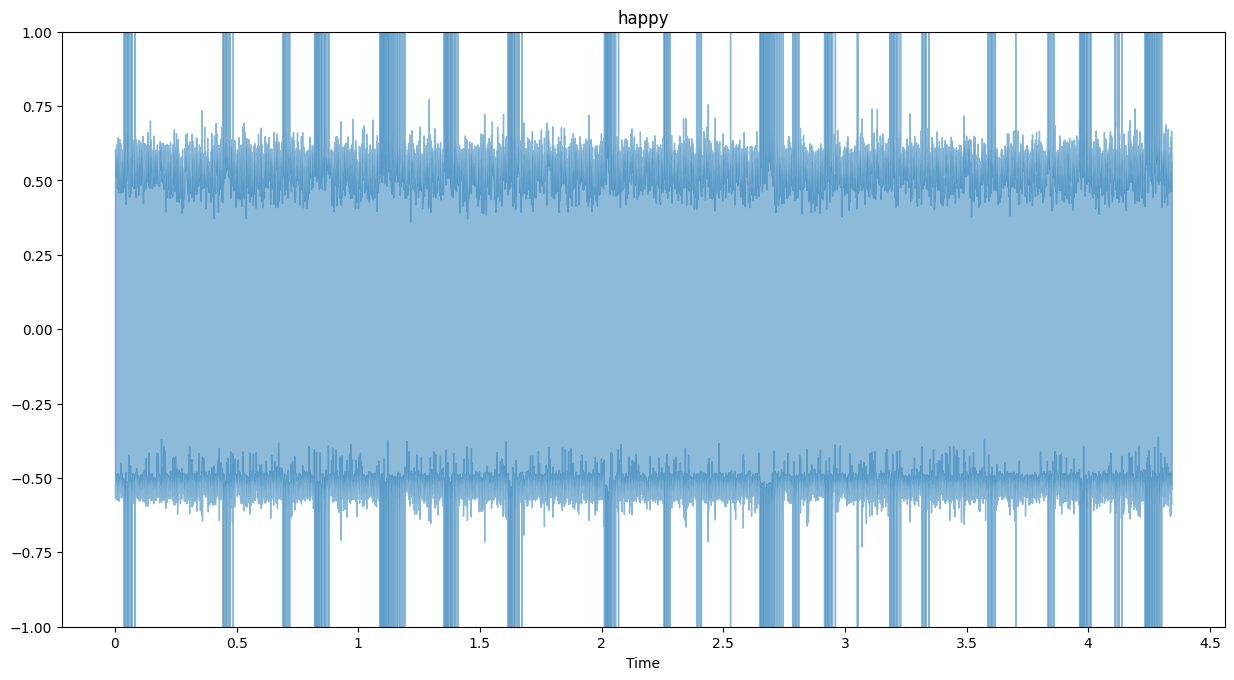

In [38]:
singal1 = new_dataxxx.reshape(-1,4).T

# YOUR CODE HERE
FRAME_SIZE = 1024
HOP_LENGTH = 512

frames = range(len(singal1))
# t = librosa.frames_to_time(frames, hop_length=HOP_LENGTH)

import matplotlib.pyplot as plt
plt.figure(figsize=(15, 17))

ax = plt.subplot(2, 1, 1)
librosa.display.waveshow(singal1, alpha=0.5)
# plt.plot(t, singal, color="r")
plt.ylim((-1, 1))
plt.title("happy")

In [40]:
import soundfile as sf

In [43]:
generated_signal_audio = new_dataxxx.reshape(-1,4).T

In [46]:
original_signal_audio = xxx.reshape(-1,4).T

In [45]:
sf.write("generated_drum.wav", generated_signal_audio.T, sample_rate)

In [47]:
sf.write("original_drum.wav", original_signal_audio.T, sample_rate)

In [48]:
from pydub import AudioSegment
audio = AudioSegment.from_wav("/kaggle/working/generated_drum.wav")
audio.export("/kaggle/working/generated_drum.mp3", format="mp3")

<_io.BufferedRandom name='/kaggle/working/generated_drum.mp3'>

In [49]:
from pydub import AudioSegment
audio = AudioSegment.from_wav("/kaggle/working/original_drum.wav")
audio.export("/kaggle/working/original_drum.mp3", format="mp3")

<_io.BufferedRandom name='/kaggle/working/original_drum.mp3'>

In [53]:
generated_output_df = pd.DataFrame(generated_signal_audio.T)
original_output_df = pd.DataFrame(original_signal_audio.T)

In [55]:
generated_output_df.to_csv("output_df.csv",index=False)
original_output_df.to_csv("input_df.csv",index=False)

In [57]:
import torchaudio

In [61]:


def plot_2spectrograms(spec1, spec2, title1=None, title2=None, ylabel="freq_bin", aspect="auto", xmax=None):
    fig, (axs1, axs2) = plt.subplots(1, 2, figsize=(12, 6))  # Adjust the figsize as needed
    axs1.set_title(title1 or "Spectrogram (db)")
    axs1.set_ylabel(ylabel)
    axs1.set_xlabel("frame")
    axs2.set_title(title2 or "Spectrogram (db)")
    axs2.set_ylabel(ylabel)
    axs2.set_xlabel("frame")
    im1 = axs1.imshow(librosa.power_to_db(spec1), origin="lower", aspect=aspect)
    im2 = axs2.imshow(librosa.power_to_db(spec2), origin="lower", aspect=aspect)
    if xmax:
        axs1.set_xlim((0, xmax))
        axs2.set_xlim((0, xmax))
    fig.colorbar(im1, ax=axs1)
    fig.colorbar(im2, ax=axs2)
    plt.tight_layout()  # Ensures proper spacing between subplots
    plt.show(block=False)



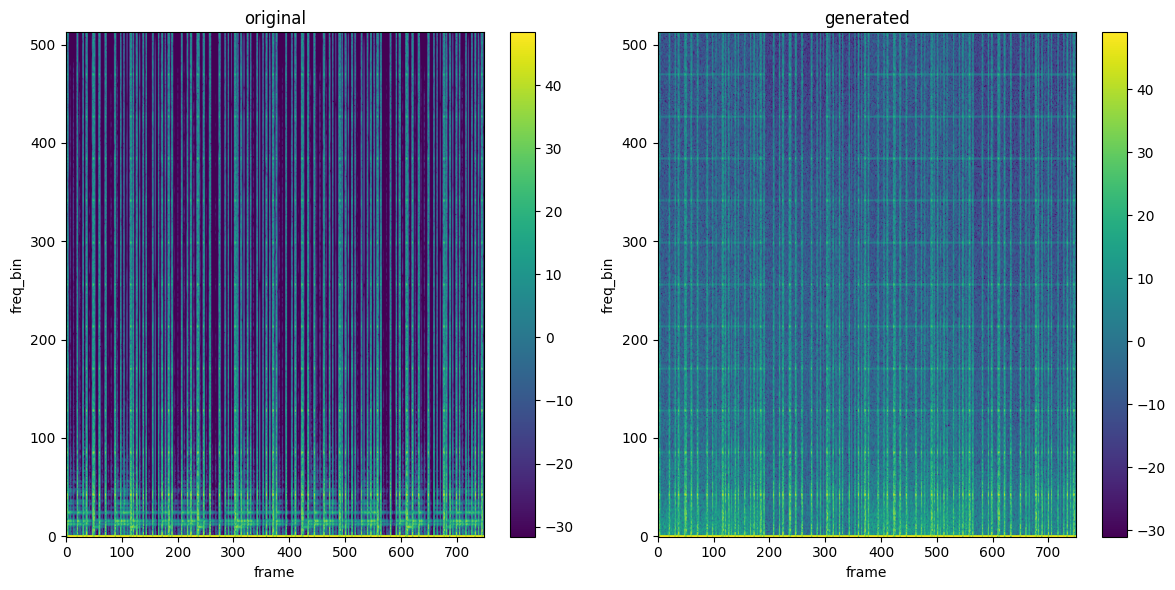

In [63]:


n_fft = 1024
win_length = None
hop_length = 512

# define transformation
spectrogram = torchaudio.transforms.Spectrogram(
    n_fft=n_fft,
    win_length=win_length,
    hop_length=hop_length,
    center=True,
    pad_mode="reflect",
    power=2.0,
)
# Perform transformation
happy_waveform = torch.tensor(original_signal_audio).reshape(1,-1)
sad_waveform = torch.tensor(generated_signal_audio).reshape(1,-1)
happy_spec = spectrogram(happy_waveform)
sad_spec = spectrogram(sad_waveform)

plot_2spectrograms(happy_spec[0], sad_spec[0], title1='original',title2='generated')



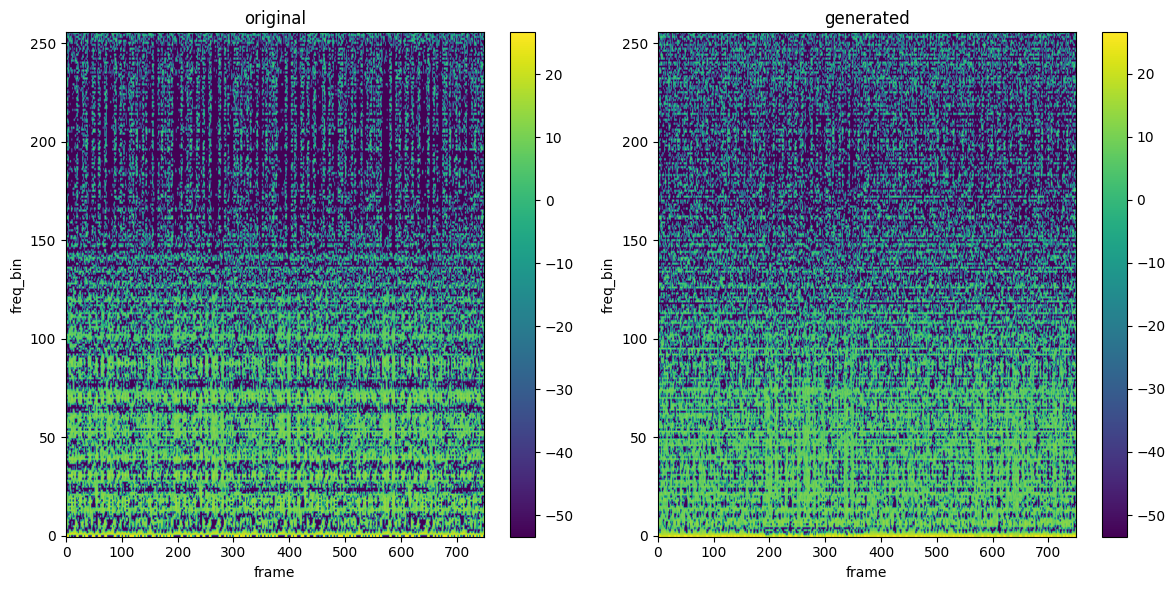

In [89]:
n_fft = 2048
win_length = None
hop_length = 512
n_mels = 256
n_mfcc = 256

mfcc_transform = torchaudio.transforms.MFCC(
    sample_rate=sample_rate,
    n_mfcc=n_mfcc,
    melkwargs={
      'n_fft': n_fft,
      'n_mels': n_mels,
      'hop_length': hop_length,
      'mel_scale': 'htk',
    }
)

mfcc1 = mfcc_transform(happy_waveform.to(torch.float32))
mfcc2 = mfcc_transform(sad_waveform)

plot_2spectrograms(mfcc1[0], mfcc2[0],title1='original',title2='generated')

In [79]:
sad_waveform.shape

torch.Size([1, 383136])

In [82]:
sad_waveform

tensor([[0.5116, 0.5389, 0.5501,  ..., 0.5027, 0.4913, 0.4907]])

In [81]:
happy_waveform

tensor([[0.5278, 0.5339, 0.5356,  ..., 0.4939, 0.4939, 0.4939]],
       dtype=torch.float64)

In [74]:
np.array(happy_waveform).astype('double')

array([[0.52784467, 0.53390902, 0.53564078, ..., 0.49388677, 0.49388686,
        0.49388686]])

In [83]:
sad_waveform.dtype

torch.float32

In [87]:
happy_waveform.to(torch.float32)

tensor([[0.5278, 0.5339, 0.5356,  ..., 0.4939, 0.4939, 0.4939]])